In [1]:
# adding required packages
import findspark
import pprint
import matplotlib.pyplot as plt

In [2]:
# To make pyspark importable as a regular library
findspark.init()

In [3]:
#importing pyspark related package
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, when, avg, round, rank, isnan, current_timestamp, date_sub, sum, desc
from pyspark.sql.window import Window

In [4]:
%run /notebook/dataproduct/assesment_nyc_job_posting/lib/data_profiling_transform.ipynb

Data profile Function Imported


In [5]:
%run /notebook/dataproduct/assesment_nyc_job_posting/lib/kpi_transform.ipynb

KPI Transformations Imported


In [6]:
%run /notebook/dataproduct/assesment_nyc_job_posting/utils/spark_session.ipynb

Spark Session Imported


In [7]:
%run /notebook/dataproduct/assesment_nyc_job_posting/lib/data_preparation.ipynb

Data Preparation Functions Imported


In [8]:
def get_spark_conf():
    # Configure Spark settings
    spark_conf = SparkConf()
    spark_conf.set("spark.executor.instances", "4") # 4 instance per node

    # Set the number of executor cores
    spark_conf.set("spark.executor.cores", "2")  # Use 2 cores per executor

    # Set the executor memory
    spark_conf.set("spark.executor.memory", "1g")  # Use 1GB memory per executor

    # Set the driver memory
    spark_conf.set("spark.driver.memory", "2g")    # Use 2GB memory for the driver
    
    return spark_conf

## Creating Spark Session

In [9]:
job_name = 'nyc_assesment'
    
#setting spark conf before creating spark session
spark_conf = get_spark_conf()

# Create a SparkSession with the configured settings
spark = get_spark_session(spark_conf, job_name)

# Listing all the spark conf
spark.sparkContext.getConf().getAll()

# setting spark conf for analysis
spark.conf.set('spark.sql.repl.eagerEval.enabled',True)

## Reading Dataset

In [10]:
#reading dataset
# adding escape charater after data profiling the data 
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True, inferSchema=True, escape='"')

In [11]:
# reducing the shuffle partition to 4 
# reason 1 data size is very less
# reason 2 to use all the availble cores
# reason 3 Since data size is very small and can be fitted in single partition but using 4 just to show data shuffling
spark.conf.set('spark.sql.shuffle.partitions',4)

## Data Profiling

In [12]:
#getting the schema
df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

In [13]:
## Display the first few rows of the DataFrame
display(df.limit(10))

Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Salary Frequency,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
405765,HUMAN RIGHTS COMM...,External,1,Associate Human R...,ASSOCIATE HUMAN R...,55038,1,Constituent Servi...,F,56746.0,56746.0,Annual,"22 Reade St, Ny",Comm.Rel.Bureau-C...,The Commission on...,1. A baccalaureat...,â€¢ Advanced work...,null,For City employee...,"DAY, 9-5; ON OCCA...","22 Reade St, Ny",null,New York City res...,2019-08-13 00:00:00,null,2019-10-29 00:00:00,2019-12-17 00:00:00
405778,DEPARTMENT OF INV...,External,1,Confidential Inve...,CONFIDENTIAL INVE...,31143,1,"Public Safety, In...",F,43799.0,55000.0,Annual,80 Maiden Lane,Default,The New York City...,1. A four-year hi...,1. Demonstrated i...,null,All current City ...,null,null,null,New York City res...,2019-08-13 00:00:00,null,2019-10-04 00:00:00,2019-12-17 00:00:00
405778,DEPARTMENT OF INV...,Internal,1,Confidential Inve...,CONFIDENTIAL INVE...,31143,1,"Public Safety, In...",F,43799.0,55000.0,Annual,80 Maiden Lane,Default,The New York City...,1. A four-year hi...,1. Demonstrated i...,null,All current City ...,null,null,null,New York City res...,2019-08-13 00:00:00,null,2019-10-04 00:00:00,2019-12-17 00:00:00
405789,DEPARTMENT OF INV...,External,1,Assistant Inspect...,CONFIDENTIAL INVE...,31143,3,"Public Safety, In...",F,62360.0,85000.0,Annual,80 Maiden Lane,Default,The New York City...,1. A four-year hi...,1. Demonstrated i...,null,All current City ...,null,null,null,New York City res...,2019-08-13 00:00:00,null,2019-10-04 00:00:00,2019-12-17 00:00:00
405789,DEPARTMENT OF INV...,Internal,1,Assistant Inspect...,CONFIDENTIAL INVE...,31143,3,"Public Safety, In...",F,62360.0,85000.0,Annual,80 Maiden Lane,Default,The New York City...,1. A four-year hi...,1. Demonstrated i...,null,All current City ...,null,null,null,New York City res...,2019-08-13 00:00:00,null,2019-10-04 00:00:00,2019-12-17 00:00:00
405795,DEPARTMENT OF TRA...,External,15,Marine Oiler,MARINE OILER(FERR...,91547,0,Building Operatio...,F,49705.0,57161.0,Annual,"1 Bay St., S.I.,Ny",F&Ga Marine Oiler...,Under direct supe...,1. Two years of f...,null,MEDICAL/DRUG TEST...,Please visit www....,32 hours/variable...,"1 Bay Street, Sta...",null,New York City res...,2019-08-29 00:00:00,null,2019-08-29 00:00:00,2019-12-17 00:00:00
405795,DEPARTMENT OF TRA...,Internal,15,Marine Oiler,MARINE OILER(FERR...,91547,0,Building Operatio...,F,49705.0,57161.0,Annual,"1 Bay St., S.I.,Ny",F&Ga Marine Oiler...,Under direct supe...,1. Two years of f...,null,MEDICAL/DRUG TEST...,Please visit www....,32 hours/variable...,"1 Bay Street, Sta...",null,New York City res...,2019-08-29 00:00:00,null,2019-08-29 00:00:00,2019-12-17 00:00:00
405824,DEPARTMENT OF INV...,External,2,Confidential Inve...,CONFIDENTIAL INVE...,31143,2,"Public Safety, In...",F,52384.0,65000.0,Annual,180 Maiden Lane,Default,The New York City...,1. A four-year hi...,1. 1-3 years co...,null,All current City ...,null,null,null,New York City res...,2019-08-14 00:00:00,2020-02-10 00:00:00,2019-12-13 00:00:00,2019-12-17 00:00:00
405824,DEPARTMENT OF INV...,Internal,2,Confidential Inve...,CONFIDENTIAL INVE...,31143,2,"Public Safety, In...",F,52384.0,65000.0,Annual,180 Maiden Lane,Default,The New York City...,1. A four-year hi...,1. 1-3 years co...,null,All current City ...,null,null,null,New York City res...,2019-08-14 00:00:00,2020-02-10 00:00:00,2019-12-13 00:00:00,2019-12-17 00:00:00
405834,DEPARTMENT OF BUS...,External,1,"PROGRAM MANAGER, ...",COMMUNITY COORDIN...,56058,0,Constituent Servi...,F,52524.0,68000.0,Annual,110 William St. N Y,Neighborhood Deve...,The Neighborhood ...,1. A baccalaureat...,â€¢A masterâ€™s d...,null,Pleas

In [14]:
# Getting counts
total_count = df.count()
print(f"Total Records: {total_count}")

Total Records: 2946


In [15]:
# Dropping duplicates
df = df.distinct()
dist_tot_cnt = df.count()
print(f"Total Records after removing duplicates: {dist_tot_cnt}")

Total Records after removing duplicates: 2915


In [16]:
print("Getting missing value counts")
missing_value_counts = calculate_missing_value_counts(df)
missing_value_counts.show(vertical=True)

Getting missing value counts
-RECORD 0-------------------------------------
 Job ID_missing                        | 0    
 Agency_missing                        | 0    
 Posting Type_missing                  | 0    
 # Of Positions_missing                | 0    
 Business Title_missing                | 0    
 Civil Service Title_missing           | 0    
 Title Code No_missing                 | 0    
 Level_missing                         | 0    
 Job Category_missing                  | 2    
 Full-Time/Part-Time indicator_missing | 193  
 Salary Range From_missing             | 0    
 Salary Range To_missing               | 0    
 Salary Frequency_missing              | 0    
 Work Location_missing                 | 0    
 Division/Work Unit_missing            | 0    
 Job Description_missing               | 0    
 Minimum Qual Requirements_missing     | 20   
 Preferred Skills_missing              | 387  
 Additional Information_missing        | 1087 
 To Apply_missing              

In [17]:
print("Getting numerical status")
numerical_columns = [col_name for col_name, col_type in df.dtypes if col_type in ["int", "double", "float"]]
summary_stats = calculate_summary_stats(df, numerical_columns)
display(summary_stats)

Getting numerical status


summary,Job ID,# Of Positions,Salary Range From,Salary Range To
mean,384863.0401372213,2.4363636363636365,58925.98743831904,85653.82161382504
stddev,53017.48027901096,8.58105496276755,27018.915415806183,42923.026785476024
min,87990,1,0.0,10.36
max,426238,200,218587.0,234402.0


Getting categorical columns
Column: Posting Type
Distinct Values: 2
Top Values:
+------------+-----+
|Posting Type|count|
+------------+-----+
|Internal    |1653 |
|External    |1262 |
+------------+-----+



<Figure size 576x432 with 0 Axes>

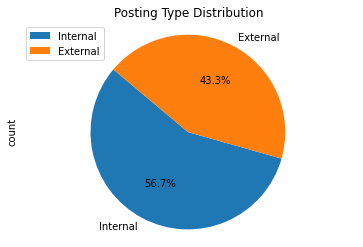

Column: Full-Time/Part-Time indicator
Distinct Values: 3
Top Values:
+-----------------------------+-----+
|Full-Time/Part-Time indicator|count|
+-----------------------------+-----+
|F                            |2597 |
|null                         |193  |
|P                            |125  |
+-----------------------------+-----+



<Figure size 576x432 with 0 Axes>

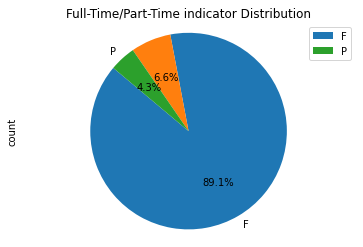

Column: Salary Frequency
Distinct Values: 3
Top Values:
+----------------+-----+
|Salary Frequency|count|
+----------------+-----+
|Annual          |2683 |
|Hourly          |194  |
|Daily           |38   |
+----------------+-----+



<Figure size 576x432 with 0 Axes>

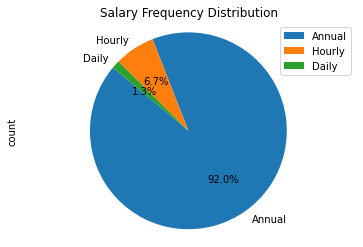

Column: Recruitment Contact
Distinct Values: 1
Top Values:
+-------------------+-----+
|Recruitment Contact|count|
+-------------------+-----+
|null               |2915 |
+-------------------+-----+



<Figure size 576x432 with 0 Axes>

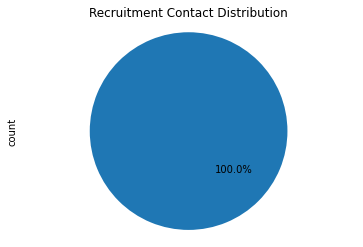

Column: Process Date
Distinct Values: 2
Top Values:
+-------------------+-----+
|Process Date       |count|
+-------------------+-----+
|2019-12-17 00:00:00|2911 |
|null               |4    |
+-------------------+-----+



<Figure size 576x432 with 0 Axes>

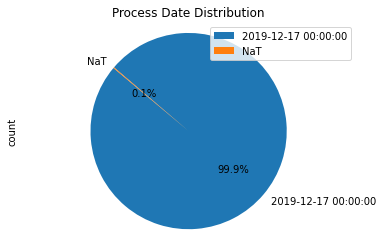

In [18]:
print("Getting categorical columns") 
# Most of the time categorical column should be string type but for this analysis -
# assuming that categorical columns can be any type.
distinct_threshold=10
for col_name in df.columns:
    is_categorical_cond, distinct_values, top_values = profile_categorical_column(df, col_name)
    if is_categorical_cond:
        print(f"Column: {col_name}")
        print(f"Distinct Values: {distinct_values}")
        print("Top Values:")
        top_values.show(truncate=False)
        pandas_df = top_values.toPandas()
        # Plot the pie chart using Pandas
        plt.figure(figsize=(8, 6))
        pandas_df.plot.pie(y="count", labels=pandas_df[f"{col_name}"], autopct="%1.1f%%", startangle=140)
        plt.axis("equal")
        plt.title(f"{col_name} Distribution")
        plt.show();


## Data Preparation

In [19]:
print("Preparing Data for KPI")

# normalizing the salary
normalize_df = normalize_salary(df)

# text preparation
kpi_df = text_preparation(normalize_df, 'Preferred Skills')

Preparing Data for KPI


## Generating KPIs

In [20]:
# KPI1 Whats the number of jobs posting per category (Top 10)? 
print("Top 10 jobs posting per category")
category_counts = get_top10_job_posting_per_cat(kpi_df)
category_counts.show(truncate=False)

Top 10 jobs posting per category
+-----------------------------------------+--------------+
|Job Category                             |No_Of_Position|
+-----------------------------------------+--------------+
|Building Operations & Maintenance        |1234          |
|Public Safety, Inspections, & Enforcement|1205          |
|Engineering, Architecture, & Planning    |755           |
|Legal Affairs                            |513           |
|Technology, Data & Innovation            |404           |
|Health                                   |358           |
|Administration & Human Resources         |321           |
|Finance, Accounting, & Procurement       |274           |
|Maintenance & Operations                 |212           |
|Policy, Research & Analysis              |200           |
+-----------------------------------------+--------------+



In [21]:
# KPI2 Whats the salary distribution per job category? 
print("The salary distribution per job category")
salary_distribution = get_sal_dist_per_cat(kpi_df)
salary_distribution.limit(10).show(truncate=False,vertical=True)

The salary distribution per job category
-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------
 Job Category  | null                                                                                                                                          
 AvgSalaryFrom | 51572.5                                                                                                                                       
 AvgSalaryTo   | 113749.5                                                                                                                                      
-RECORD 1------------------------------------------------------------------------------------------------------------------------------------------------------
 Job Category  | Administration & Human Resources                                                                                                              

In [22]:
#KPI3 3: Correlation between higher degree and salary
print('Correlation between higher degree and salary')
get_corr_higher_degree_salary(kpi_df)

Correlation between higher degree and salary


0.23604203424261916

In [23]:
#KPI4 Whats the job posting having the highest salary per agency? 
print("The job posting having the highest salary per agency")
max_sal_per_agency_df = get_highes_sal_per_cat(kpi_df)
max_sal_per_agency_df.show(truncate=False)

The job posting having the highest salary per agency
+------------------------------+------------------------------------------------------------+--------------+
|Agency                        |Business Title                                              |Highest Salary|
+------------------------------+------------------------------------------------------------+--------------+
|DEPARTMENT OF BUILDINGS       |Borough Enforcement Attorney                                |82137.0       |
|DEPARTMENT OF FINANCE         |Senior Director                                             |140000.0      |
|DEPT. OF HOMELESS SERVICES    |DHS OVERDOSE PREVENTION COORDINATOR                         |92001.0       |
|FIRE DEPARTMENT               |Senior Enterprise Applications Integration Developer        |144929.0      |
|HOUSING PRESERVATION & DVLPMNT|Assistant Commissioner of Community Partnerships and Finance|140000.0      |
|HRA/DEPT OF SOCIAL SERVICES   |EXECUTIVE DIRECTOR, SERVER INFRASTRUCTURE -

In [24]:
#KPI5: Whats the job positings average salary per agency for the last 2 years
print("The average salary per agency for the last 2 years")
last_n_year = 4
avg_salary_df = get_avg_sal_per_agency_last_n_year(kpi_df,last_n_year)
avg_salary_df.show(truncate=False)

The average salary per agency for the last 2 years
+------------------------------+----------------------+--------------------+
|Agency                        |Avg_Annual_Salary_From|Avg_Annual_Salary_To|
+------------------------------+----------------------+--------------------+
|HRA/DEPT OF SOCIAL SERVICES   |62180.88              |86805.46            |
|DEPARTMENT OF FINANCE         |68758.75              |90428.92            |
|HOUSING PRESERVATION & DVLPMNT|74863.93              |85905.52            |
|DEPT. OF HOMELESS SERVICES    |39082.0               |55301.67            |
|FIRE DEPARTMENT               |79965.98              |93000.73            |
|OFFICE OF MANAGEMENT & BUDGET |65394.13              |77656.04            |
|DEPARTMENT OF BUILDINGS       |45581.47              |55310.6             |
|TEACHERS RETIREMENT SYSTEM    |62397.0               |75760.0             |
|DEPT OF HEALTH/MENTAL HYGIENE |61872.37              |79865.25            |
|DEPARTMENT OF TRANSPORTA

In [25]:
#KPI6: What are the highest paid skills in the US market
highest_paid_skill_df = top_highest_paid_job_postings(kpi_df, sample_size=100)
highest_paid_skill_df.show(truncate=False)

+-------------+-----+
|skills       |count|
+-------------+-----+
|experience   |247  |
|management   |153  |
|skill        |147  |
|ability      |114  |
|knowledge    |106  |
|project      |106  |
|year         |92   |
|strong       |84   |
|communication|75   |
|engineering  |65   |
|construction |57   |
|public       |55   |
|work         |55   |
|excellent    |54   |
|design       |51   |
|large        |50   |
|written      |48   |
|team         |48   |
|candidate    |48   |
|staff        |47   |
+-------------+-----+
only showing top 20 rows



In [34]:
kpi_df.coalesce(1).write.mode('overwrite').format('csv').save('/dataset/output/nyc-jobs_output')

## Renaming the output file and delete all the tmp files.

In [35]:
%%bash
#!/bin/bash
# Iterate through files in the directory
directory="/dataset/output/nyc-jobs_output"
pattern="part-*"
new_filename="nyc-jobs-output.csv"

for file in "$directory/"* "$directory"/.*; do
    # Extract the filename from the full path
    filename=$(basename "$file")
    echo "$filename"
    
    # Exclude special directories . and ..
    if [[ "$file" == "$directory/." || "$file" == "$directory/.." ]]; then
        continue
    fi
    
    if [[ "$filename" == $pattern ]]; then
        echo "File '$filename' matches the pattern."
        # Rename the file by adding a prefix
        mv "$file" "$directory"/$new_filename
        echo "Renamed to '$new_filename'."
    else
        echo "File '$filename' doesn't match the pattern. Deleting..."
        # Uncomment the line below to actually delete the file
        rm "$file"
        echo "File deleted."
    fi
done

_SUCCESS
File '_SUCCESS' doesn't match the pattern. Deleting...
File deleted.
part-00000-32bd568c-f61d-4f87-8023-5f4a752adc89-c000.csv
File 'part-00000-32bd568c-f61d-4f87-8023-5f4a752adc89-c000.csv' matches the pattern.
Renamed to 'nyc-jobs-output.csv'.
.
..
._SUCCESS.crc
File '._SUCCESS.crc' doesn't match the pattern. Deleting...
File deleted.
.part-00000-32bd568c-f61d-4f87-8023-5f4a752adc89-c000.csv.crc
File '.part-00000-32bd568c-f61d-4f87-8023-5f4a752adc89-c000.csv.crc' doesn't match the pattern. Deleting...
File deleted.
